In [0]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
### YOUR CODE HERE
# Figure out how to import regularizers
from tensorflow.keras import regularizers
###
import tensorflow.keras.utils as ku 
import numpy as np 

In [12]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

corpus = data.lower().split("\n")


tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

--2020-03-09 05:38:05--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.11.80, 2607:f8b0:4007:803::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.11.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2020-03-09 05:38:05 (117 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [21]:
DESIRED_ACCURACY = 0.75
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc') > DESIRED_ACCURACY):
      print("\nReached 75% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()


model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len - 1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
# Pick an optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 10, 100)           321100    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 10, 300)           301200    
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 300)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_4 (Dense)              (None, 1605)              162105    
_________________________________________________________________
dense_5 (Dense)              (None, 3211)              5156866   
Total params: 6,101,671
Trainable params: 6,101,671
Non-trainable params: 0
____________________________________________

In [22]:
 history = model.fit(predictors, label, epochs=100, verbose=1, callbacks = [callbacks])

Train on 15462 samples
Epoch 1/100
15462/15462 [==============================] - 24s 2ms/sample - loss: 6.9137 - acc: 0.0241
Epoch 2/100
15462/15462 [==============================] - 23s 1ms/sample - loss: 6.4823 - acc: 0.0264
Epoch 3/100
15462/15462 [==============================] - 23s 1ms/sample - loss: 6.3394 - acc: 0.0310
Epoch 4/100
15462/15462 [==============================] - 22s 1ms/sample - loss: 6.2317 - acc: 0.0323
Epoch 5/100
15462/15462 [==============================] - 22s 1ms/sample - loss: 6.1371 - acc: 0.0367
Epoch 6/100
15462/15462 [==============================] - 22s 1ms/sample - loss: 6.0418 - acc: 0.0385
Epoch 7/100
15462/15462 [==============================] - 23s 1ms/sample - loss: 5.9578 - acc: 0.0420
Epoch 8/100
15462/15462 [==============================] - 23s 1ms/sample - loss: 5.8701 - acc: 0.0449
Epoch 9/100
15462/15462 [==============================] - 23s 2ms/sample - loss: 5.7867 - acc: 0.0528
Epoch 10/100
15462/15462 [========================

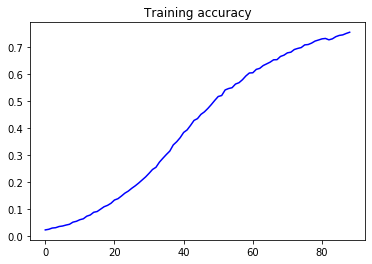

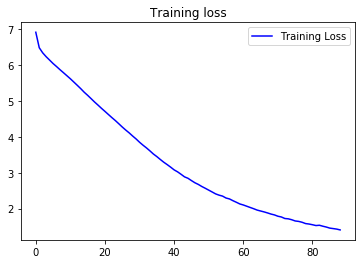

In [23]:
import matplotlib.pyplot as plt
acc = history.history['acc']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [24]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Help me Obi Wan Kenobi, you're my only hope of thine eyes brings forth thee still bright ill perjured ' o'er foes ride be bold some wretch be some wantonness care away be shown grow away to tell thee o'er care or touch'd esteem'd spent grow bright well kind dwell away bright taken ' bright be bright made when too about new pride light 'not you ' forth gone still thee doth not too dyed new new new right fall still still new reign pride lies go rolling hours so say that you eye doth view tell every wrong ' straight alone deem'd grow away with other date past
